# Build SVM Classifiers based on annotated data

## Load data

The data given is in **`brat`** format. We have to parse it first and then extract the sentences and their topics.

In [1]:
from bratreader.repomodel import RepoModel

ann1 = RepoModel("data_annotated/AnnotationWorkshop/Ann1")
ann2 = RepoModel("data_annotated/AnnotationWorkshop/Ann2")
ann3 = RepoModel("data_annotated/AnnotationWorkshop/Ann3")
ann4 = RepoModel("data_annotated/AnnotationWorkshop/Ann4")
ann5 = RepoModel("data_annotated/AnnotationWorkshop/Ann5")
ann6 = RepoModel("data_annotated/AnnotationWorkshop/Ann6")

ann7 = RepoModel("data_annotated/AnnotationWorkshop2/Alina")
ann8 = RepoModel("data_annotated/AnnotationWorkshop2/Mayra")
ann9 = RepoModel("data_annotated/AnnotationWorkshop2/Nick")
ann10 = RepoModel("data_annotated/AnnotationWorkshop2/Penny")
ann11 = RepoModel("data_annotated/ZSI")

ann12 = RepoModel("data_annotated/MayAnnotationTask/Alina")
ann13 = RepoModel("data_annotated/MayAnnotationTask/Alina2")
ann14 = RepoModel("data_annotated/MayAnnotationTask/Total")
ann15 = RepoModel("data_annotated/MayAnnotationTask/ZSI1")
ann16 = RepoModel("data_annotated/MayAnnotationTask/ZSI2")

In [2]:
ann1d = list(ann1.documents.values())
ann2d = list(ann2.documents.values())
ann3d = list(ann3.documents.values())
ann4d = list(ann4.documents.values())
ann5d = list(ann5.documents.values())
ann6d = list(ann6.documents.values())

ann7d = list(ann7.documents.values())
ann8d = list(ann8.documents.values())
ann9d = list(ann9.documents.values())
ann10d = list(ann10.documents.values())
ann11d = list(ann11.documents.values())

ann12d = list(ann12.documents.values())
ann13d = list(ann13.documents.values())
ann14d = list(ann14.documents.values())
ann15d = list(ann15.documents.values())
ann16d = list(ann16.documents.values())

In [3]:
documents = ann1d + ann2d + ann3d + ann4d + ann5d + ann6d + ann7d + ann8d + ann9d + ann10d + ann11d 
#+ ann12d + ann13d + ann14d + ann15d + ann16d

Take all the sentences from each document and put them in one big list

In [4]:
def remove_topic_subcategory(topic):
    stripped = topic.split('_')
    if len(stripped) == 3: 
        return stripped[1]
    elif len(stripped) == 1:
        return stripped[0]
    elif len(stripped) == 2:
        return stripped[1]
    else:
        raise Exception('Unknown type of Topic: ' + topic)

In [5]:
sentences = list()
sentences_topics = list()

Remove duplicate sentences and remove subtopics

In [6]:
for document in documents:
    for sentence in document.sentences:
        sent = ' '.join([w.form for w in sentence.words])
        if sent in sentences:
            index = sentences.index(sent)
            sentences_topics[index] += list(set([remove_topic_subcategory(keys) for w in sentence.words for annotation in w.annotations for keys in annotation.labels.keys()]))
        else:
            sentences.append(sent)
            sentences_topics.append(list(set([remove_topic_subcategory(keys) for w in sentence.words for annotation in w.annotations for keys in annotation.labels.keys()])))

Here are the different kinds of topics annotated to all sentences

In [7]:
topic_types = set([topic for sentence_topics in sentences_topics for topic in sentence_topics])
print(topic_types)

{'Actors', 'Outputs', 'ProjectMark', 'SpamProject', 'Innovativeness', 'Objective'}


## Preprocess the data

In [8]:
import re

def remove_string_special_characters(s):
    # Replace special character with ' '
    stripped = re.sub('[^\w.!?%\s]', '', s)
    stripped = re.sub('_', '', stripped)

    # Change any whitespace to one space
    stripped = re.sub('\s+', ' ', stripped)

    # Remove start and end white spaces
    stripped = stripped.strip()
    
    return stripped

In [9]:
def remove_html_tags(text):
    return re.sub('<[^<]+?>', '', text).replace('\n', '')

In [10]:
from boilerpipe.extract import Extractor
def extract_text_from_crawl(text):
    try:
        extractor = Extractor(extractor='ArticleExtractor', html=text)
        return extractor.getText()
    except:
        print("Text unreadable")
        return None

In [11]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame({'sentences': sentences, 'topics': sentences_topics})

In [12]:
df.sentences = df.sentences.apply(lambda text: remove_string_special_characters(text))
df.sentences = df.sentences.apply(lambda text: remove_html_tags(text))
df.sentences = df.sentences.apply(lambda text: extract_text_from_crawl(text))

Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable
Text unreadable


In [13]:
import spacy
nlp = spacy.load('en_core_web_sm')

def check_sentence_has_verb(tokens):
    for token in tokens:
        if token.pos_ == 'VERB':
            return True
    return False

In [14]:
MAX_CONSECUTIVE_NOUNS = 5
def check_sentence_for_consecutive_nouns(tokens):
    nounsCounter = 0
    for token in tokens:
        if token.pos_ == 'NOUN':
            nounsCounter += 1
            if nounsCounter >= MAX_CONSECUTIVE_NOUNS:
                return True
        else: 
            nounsCounter = 0
    return False

In [15]:
def check_sentence_is_valid(sentence):
    tokens = nlp(sentence)
    return check_sentence_has_verb(tokens) and not check_sentence_for_consecutive_nouns(tokens)

In [16]:
from nltk.tokenize import sent_tokenize, word_tokenize
MIN_SENT_WORDS_LEN = 3
MAX_SENT_WORDS_LEN = 55

def filter_sentence(text):
    if text == None:
        return None
    if len(word_tokenize(text)) > MIN_SENT_WORDS_LEN and len(word_tokenize(text)) < MAX_SENT_WORDS_LEN and check_sentence_is_valid(text):
        return text
    return None

In [17]:
df.sentences = df.sentences.apply(lambda text: filter_sentence(text))

In [18]:
sentences = df.dropna().sentences.values
sentences_topics = df.dropna().topics.values

In [19]:
sentences.shape

(4323,)

## Objective SVM 

Filter out the data to get objective topics for sentences only

In [20]:
objective_topics = list()
for topics in sentences_topics:
    if 'Objective' in topics:
        objective_topics.append(1)
    else:
        objective_topics.append(0)

In [21]:
testDataLen = int(len(sentences) * 0.20)
X_train = sentences[:-testDataLen]
y_train = objective_topics[:-testDataLen]
X_test = sentences[-testDataLen:]
y_test = objective_topics[-testDataLen:]

In [22]:
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from stemmed_vectorizer import StemmedCountVectorizer

pipe = Pipeline([
#                 ('vect', CountVectorizer()),
                 ('vect', StemmedCountVectorizer(stop_words='english')), 
                 ('tfidf', TfidfTransformer()),
                 ('sampling', NearMiss(version=2)),
#                 ('sampling', CondensedNearestNeighbour(random_state=0)),
#                 ('sampling', RandomUnderSampler()),
#                 ('svm', LinearSVC(C=1.0)),
                 ('clf-svm', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, max_iter=4, random_state=42)),
#                 ('mnb', MultinomialNB(fit_prior=False))
])
objective_svm = pipe.fit(X_train, y_train)
y_pred = objective_svm.predict(X_test)
print(np.mean(y_pred == y_test))

0.5601851851851852


Confusion matrix, without normalization
[[383 358]
 [ 22 101]]
Normalized confusion matrix
[[0.52 0.48]
 [0.18 0.82]]


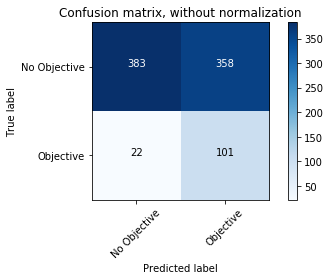

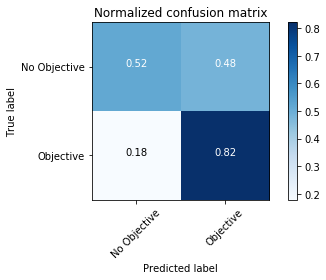

In [23]:
from helpers import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Objective', 'Objective'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Objective', 'Objective'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Actors SVM

In [24]:
actor_topics = list()
for topics in sentences_topics:
    if 'Actors' in topics:
        actor_topics.append(1)
    else:
        actor_topics.append(0)

In [25]:
testDataLen = int(len(sentences) * 0.20)
X_train = sentences[:-testDataLen]
y_train = actor_topics[:-testDataLen]
X_test = sentences[-testDataLen:]
y_test = actor_topics[-testDataLen:]

In [26]:
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from stemmed_vectorizer import StemmedCountVectorizer

pipe = Pipeline([
#                 ('vect', CountVectorizer()),
                 ('vect', StemmedCountVectorizer(stop_words='english')), 
                 ('tfidf', TfidfTransformer()),
                 ('sampling', NearMiss(version=3)),
#                 ('sampling', CondensedNearestNeighbour(random_state=0)),
#                 ('sampling', RandomUnderSampler()),
#                 ('svm', LinearSVC(C=1.0)),
                 ('clf-svm', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, max_iter=4, random_state=42)),
#                 ('mnb', MultinomialNB(fit_prior=False))
])
actor_svm = pipe.fit(X_train, y_train)
y_pred = actor_svm.predict(X_test)
print(np.mean(y_pred == y_test))

0.6284722222222222


Confusion matrix, without normalization
[[502 286]
 [ 35  41]]
Normalized confusion matrix
[[0.64 0.36]
 [0.46 0.54]]


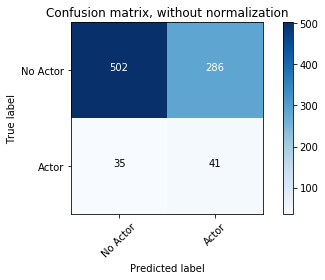

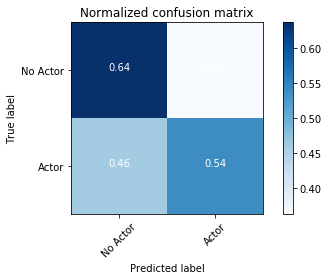

In [27]:
from helpers import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Actor', 'Actor'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Actor', 'Actor'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Innovation SVM

In [28]:
innovation_topics = list()
for topics in sentences_topics:
    if 'Innovativeness' in topics:
        innovation_topics.append(1)
    else:
        innovation_topics.append(0)

In [29]:
testDataLen = int(len(sentences) * 0.20)
X_train = sentences[:-testDataLen]
y_train = innovation_topics[:-testDataLen]
X_test = sentences[-testDataLen:]
y_test = innovation_topics[-testDataLen:]

In [30]:
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from stemmed_vectorizer import StemmedCountVectorizer

pipe = Pipeline([
#                 ('vect', CountVectorizer()),
                 ('vect', StemmedCountVectorizer(stop_words='english')), 
                 ('tfidf', TfidfTransformer()),
                 ('sampling', NearMiss(version=2)),
#                 ('sampling', CondensedNearestNeighbour(random_state=0)),
#                 ('sampling', RandomUnderSampler()),
#                 ('svm', LinearSVC(C=1.0)),
                 ('clf-svm', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, max_iter=4, random_state=42))
])
innovation_svm = pipe.fit(X_train, y_train)
y_pred = innovation_svm.predict(X_test)
print(np.mean(y_pred == y_test))

0.44560185185185186


Confusion matrix, without normalization
[[297 455]
 [ 24  88]]
Normalized confusion matrix
[[0.39 0.61]
 [0.21 0.79]]


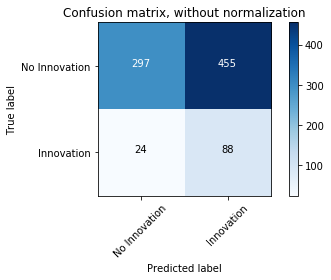

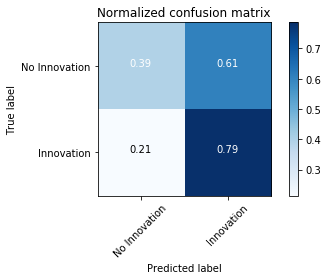

In [31]:
from helpers import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Innovation', 'Innovation'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Innovation', 'Innovation'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Output SVM

In [32]:
output_topics = list()
for topics in sentences_topics:
    if 'Outputs' in topics:
        output_topics.append(1)
    else:
        output_topics.append(0)

In [33]:
testDataLen = int(len(sentences) * 0.20)
X_train = sentences[:-testDataLen]
y_train = actor_topics[:-testDataLen]
X_test = sentences[-testDataLen:]
y_test = actor_topics[-testDataLen:]

In [34]:
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from stemmed_vectorizer import StemmedCountVectorizer

pipe = Pipeline([
#                 ('vect', CountVectorizer()),
                 ('vect', StemmedCountVectorizer(stop_words='english')), 
                 ('tfidf', TfidfTransformer()),
                 ('sampling', NearMiss(version=3)),
#                 ('sampling', CondensedNearestNeighbour(random_state=0)),
#                 ('sampling', RandomUnderSampler()),
#                 ('svm', LinearSVC(C=1.0)),
                 ('clf-svm', SGDClassifier(loss='log', penalty='l2',alpha=1e-3, max_iter=4, random_state=42)),
#                 ('mnb', MultinomialNB(fit_prior=False))
])
output_svm = pipe.fit(X_train, y_train)
y_pred = output_svm.predict(X_test)
print(np.mean(y_pred == y_test))

0.6284722222222222


Confusion matrix, without normalization
[[502 286]
 [ 35  41]]
Normalized confusion matrix
[[0.64 0.36]
 [0.46 0.54]]


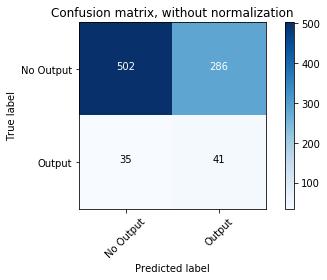

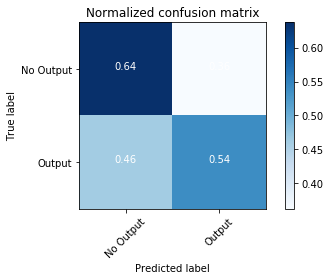

In [35]:
from helpers import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Output', 'Output'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Output', 'Output'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Test the Classifiers

In [36]:
df = pd.read_json('test_data.json', lines=True)

In [90]:
TOPIC_SENTENCES_COUNT = 1

def convert_to_labels(sent_probs):
    probs = sent_probs.copy()
    probs[::-1].sort()
    for index, prob in enumerate(sent_probs):
        if prob in probs[:TOPIC_SENTENCES_COUNT]:
            sent_probs[index] = 1
        else:
            sent_probs[index] = 0
    return sent_probs

In [91]:
from nltk import sent_tokenize

def get_summary_by_prob(entry):
    if '\n' in entry.doc:
        sents = entry.doc.split('\n')
    else:
        sents = sent_tokenize(entry.doc)
    objectives = convert_to_labels(objective_svm.predict_proba(sents)[:,1])
    actors = convert_to_labels(actor_svm.predict_proba(sents)[:,1])
    innovations = convert_to_labels(innovation_svm.predict_proba(sents)[:,1])
    outputs = convert_to_labels(output_svm.predict_proba(sents)[:,1])
    
    predicted = np.logical_or(objectives, actors)
    predicted = np.logical_or(predicted, innovations)
    predicted = np.logical_or(predicted, outputs)

    summary = list()
    for index, predict in enumerate(predicted):
        if int(predict) == 1:
            summary.append(sents[index])
    return ' '.join(summary)

df['topics_prob_summary'] = df.apply(lambda x: get_summary_by_prob(x), axis=1)

In [74]:
def get_summary(entry):
    sents = entry.doc.split('\n')
    
    objectives = objective_svm.predict(sents)
    actors = actor_svm.predict(sents)
    innovations = innovation_svm.predict(sents)
    outputs = output_svm.predict(sents)
    
    predicted = np.logical_or(objectives, actors)
    predicted = np.logical_or(predicted, innovations)
    predicted = np.logical_or(predicted, outputs)
    
    summary = list()
    for index, predict in enumerate(predicted):
        if int(predict) == 1:
            summary.append(sents[index])
    return ' '.join(summary)

df['topics_summary'] = df.apply(lambda x: get_summary(x), axis=1)

In [145]:
df.head()

doc  \
0  CATCH Healthy Habits Uniting children and adults age 50 in the fight against obesity Come join OASIS CATCH Healthy Habits the nations largest evidencebased intergenerational health program that unites caring adult volunteers to inspire children to adopt healthy eating and physical activity habits for a lifetime.\nTeams of volunteers work with children in after school and summer programs for up to 25 weeks.\nEach onehour session includes at least 30 minutes of fun active games handson nutrition lessons and a healthy snack.\nThe program is based on the Coordinated Approach to Child Health CATCH aligns with the Let s Move!\ncampaign and meets National Health Education Standards.\nKids and volunteers discover how much fun it is to eat better and move more.\nAdditional adults 50 benefit from wellness workshops based upon the CATCH approach.\nCATCH Healthy Habits is offered in 21 U.S. cities across 17 states through partnerships with more than 300 schools Boys Girls Clubs YMCAs and other sites.\nThe program is nationally sponsored by Anthem Foundation.\nBoth children and adults ate more fruits and veggies and cut down on screen time.\n75000 Volunteer hours valued at 1.5 million over 77 million media reach www.CATCHHealthyHabits.org Contact Peter Holtgrave OASIS National Health Manager 314.862.2933 or pholtgraveoasisnet.org Anthem Foundation was a finalist for the U.S. Chamber of Commerce Corporate Citizenship Award for its national support of the program.\nThe OASIS Institute is a national nonprofit organization that promotes successful aging through lifelong learning health programs and volunteer engagement.\nActive ageing is a process that takes place over the life course but in many societies there is a growing issue with increasing levels of childhood obesity leading to a growing proportion of adults also being overweight and obese.\nBeing overweight or obese as a child can have immediate consequences in terms of lower levels of mental wellbeing and in the more severe instances the early diagnosis of diseases such as type 2 diabetes at much earlier ages than has been seen in the past.\nEnsuring that children start their lives well is essential for them to maximise their potential to lead a healthy life over the whole of the life course.\nIn the USA nearly one in three children are overweight or obese and this poses a very real risk that the current generation of children will lead lives that are less healthy and perhaps even shorter than the current generation.\nThere is clearly considerable scope for the development of social innovations to address this major public health challenge.\nThe National Institute of Health developed the Coordinated Approach To Child Health CATCH as an evidence based intervention to combat childhood obesity based on the best available scientific evidence.\nIt advocated increasing levels of physical activity among children and education about healthy diets and living from an early age but the NIH found it difficult to implement the programme on a sufficiently large scale due to lack of funding and capacity.\nThe socially innovative solution to this implementation difficulty was to use existing networks of voluntary organisations to assist with running the programme.\nOASIS is a national organisation for older people aged 50 years and over that was established in 1982 to promote lifelong learning and active ageing and provided an ideal partner organisation to actually implement the CATCH programme.\nOASIS with funding from charitable foundations and the NIH was able to train and support older volunteers to go into schools to do an hour of fun physical exercise with children in the 5 to 11 years age range.\nThe older volunteers typically relatively fit and active older people in their fifties and sixties work with small groups of children in physical exercise activities and informal classes on healthy diets and lifestyles.\nThe CATCH programme now operates in 21 cities across 17 states with mor

In [146]:
with open('test_data.json', 'w') as f:
    f.write(df.to_json(orient='records', lines=True))

## Use OneVsRestClassifier to combine all SVMs in one Pipeline

In [527]:
all_topics = list()
for topics in sentences_topics:
    sent_topics = list()
    if 'Objective' in topics:
        sent_topics.append(0)    
    if 'Actors' in topics:
        sent_topics.append(1)    
    if 'Innovativeness' in topics:
        sent_topics.append(2)    
    if 'Outputs' in topics:
        sent_topics.append(3)    
    all_topics.append(sent_topics)

In [528]:
#np.column_stack((np.array(objective_topics),np.array(actor_topics),np.array(innovation_topics),np.array(output_topics)))

In [529]:
testDataLen = int(len(sentences) * 0.20)
X_train = sentences[:-testDataLen]
y_train = all_topics[:-testDataLen]
X_test = sentences[-testDataLen:]
y_test = all_topics[-testDataLen:]

In [530]:
from sklearn.preprocessing import MultiLabelBinarizer
y_train = MultiLabelBinarizer().fit_transform(y_train)
y_test = MultiLabelBinarizer().fit_transform(y_test)

In [531]:
len(y_train)

16836

In [532]:
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from stemmed_vectorizer import StemmedCountVectorizer
from sklearn.multiclass import OneVsRestClassifier

pipe = Pipeline([
#                 ('vect', CountVectorizer()),
                 ('vect', StemmedCountVectorizer(stop_words='english')), 
                 ('tfidf', TfidfTransformer()),
                 ('sampling', NearMiss(version=1)),
#                 ('sampling', CondensedNearestNeighbour(random_state=0)),
#                 ('sampling', RandomUnderSampler()),
#                 ('svm', LinearSVC(C=1.0)),
                 ('clf-svm', OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))),
#                 ('mnb', MultinomialNB(fit_prior=False))
])
svm = pipe.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(np.mean(y_pred == y_test))

0.7754277566539924


In [ ]:
np.set_printoptions(threshold=np.nan)
y_pred

Confusion matrix, without normalization
[[12987  3541]
 [  239    65]]
Normalized confusion matrix
[[0.79 0.21]
 [0.79 0.21]]


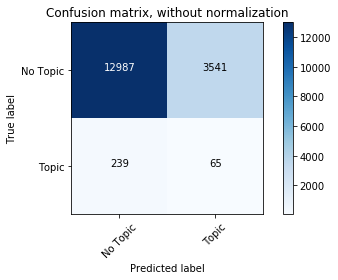

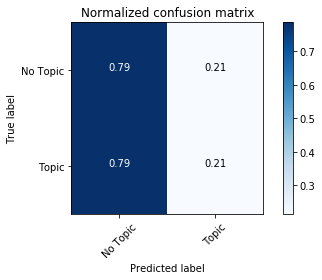

In [533]:
from helpers import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.flatten(), y_pred.flatten())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Topic', 'Topic'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Topic', 'Topic'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [472]:
#df1 = df[df['topics_summary'] != '']
df1 = df

# SVM Word level ROUGE score

In [ ]:
from rouge import Rouge 

hypothesis = df1.svm_summary.values

reference = df1.cosine_summary.values

rouge = Rouge()
rouge.get_scores(hypothesis, reference, avg=True)

# SVM Topics ROUGE score

In [474]:
hypothesis = df1.topics_summary.values

reference = df1.cosine_summary.values

rouge = Rouge()
rouge.get_scores(hypothesis, reference, avg=True)

{'rouge-1': {'f': 0.639133384748814,
  'p': 0.5727001063313125,
  'r': 0.9749093120534427},
 'rouge-2': {'f': 0.6123691332176808,
  'p': 0.5538479262878484,
  'r': 0.9575242393168895},
 'rouge-l': {'f': 0.5844807172834656,
  'p': 0.5721432106524657,
  'r': 0.9718879275392125}}

# SVM 2 sents from topic ROUGE score

In [475]:
hypothesis = df1.topics_prob_summary.values

reference = df1.cosine_summary.values

rouge = Rouge()
rouge.get_scores(hypothesis, reference, avg=True)

{'rouge-1': {'f': 0.5672124463694098,
  'p': 0.667504441329886,
  'r': 0.559260804712771},
 'rouge-2': {'f': 0.47973244784681257,
  'p': 0.6015086968207924,
  'r': 0.461459513450797},
 'rouge-l': {'f': 0.5085478759368719,
  'p': 0.6604134289066691,
  'r': 0.5506251842813712}}

# Serialize and save models

In [477]:
from joblib import dump, load
dump(objective_svm, 'objective_svm.joblib') 
dump(actor_svm, 'actor_svm.joblib') 
dump(innovation_svm, 'innovation_svm.joblib') 
dump(output_svm, 'output_svm.joblib') 

['output_svm.joblib']

In [606]:
with open('rouge_scored_svms.json', 'w') as f:
    f.write(df1.to_json(orient='records', lines=True))

In [616]:
dfsumarunner = pd.read_json('rouge_scored_svms.json', lines=True)

In [617]:
hypothesis = dfsumarunner.sumarunner_summary.values

reference = dfsumarunner.cosine_summary.values

rouge = Rouge()
rouge.get_scores(hypothesis, reference, avg=True)

{'rouge-1': {'f': 0.6426134874634812,
  'p': 0.8447450951968886,
  'r': 0.5719274827098424},
 'rouge-2': {'f': 0.5788165017138015,
  'p': 0.8080869554046661,
  'r': 0.5138469970629544},
 'rouge-l': {'f': 0.5762641098038733,
  'p': 0.8413025953491167,
  'r': 0.5697226422278977}}

## Use models on a test dataset

In [110]:
df = pd.read_json('../../demo_data.json')

In [111]:
df['sic_summary'] = df.apply(lambda x: get_summary_by_prob(x), axis=1)

In [112]:
#df[['doc', 'summarunner_summary', 'svm_summary', 'sic_summary']]
for index, row in df.iterrows():
    print("\nDocument\n")
    print(row['doc'])
    print("\n1st Approach\n")
    print(row['summarunner_summary'])
    print("\n2nd Approach\n")
    print(row['svm_summary'])
    print("\n3rd Approach\n")
    print(row['sic_summary'])


Document

Contact About the Project 2015 Club Application for the Club of the Academy How to find a job Jobs Advisory Do you have any advice how looking for work ? Company ID 463 51 655 Tax ID CZ 463 51 655 Registered office K. Světlé 558 Řevnice copy 20142018 GO 50 GO Implementation and SEO CCN PLUS s.r.o. JS Good quality paid work or employment is an important social element of health and a major contributor to active ageing. If work is stressful insecure and hazardous then it has negative effects on health and wellbeing over the life course and therefore undermines the potential of people groups and the whole population to age well. Unemployment frequently has negative effects on peoples standard of living and if it is over a longterm period can reduce their sense of selfesteem and increased the risk of entering poor health. Older people can find it particularly difficult to find another job when they are in their fifties and sixties due to age discrimination and this is an element

In [81]:
with open('../../demo_data.json', 'w') as f:
    f.write(df.to_json(orient='records'))